# Cancer de Pele
    Algoritmo de deteção de doenças de pele

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import pydicom
import os
import glob
import pickle
import pandas as pd
import csv
import cv2
from pathlib import Path
from IPython.display import HTML
from os import listdir, mkdir
import imageio
from IPython import display
from sklearn.metrics import roc_auc_score, roc_curve, auc
import scipy
from numpy import asarray
from numpy import random as rd

import tensorflow as tf
from keras.models import load_model
from keras import layers 
from keras.layers import Concatenate,Input, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D 
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, \
GlobalAveragePooling2D 
from keras.models import Model, Sequential 
from keras.preprocessing import image 
from keras.utils import layer_utils 
from keras.utils.data_utils import get_file 
from keras.applications.imagenet_utils import preprocess_input 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator

## Data exploration

In [2]:
dados = pd.read_csv('HAM10000_metadata.csv')
dados.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
dados.info

<bound method DataFrame.info of          lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]>

In [4]:
dados['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

## Augmentation

In [6]:
def augmentation(img):
   
    data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomRotation(0.015)]) 
    
    imgA = np.zeros((9,250,250,3)) 
    mean = 0
    var = .005
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (250, 250,3)) 
    image = tf.expand_dims(img, 0)
    imgA[0,:,:,:] = tf.image.flip_left_right(img) 
    imgA[1,:,:,:] = augmented_image = data_augmentation(image)
    imgA[2,:,:,:] = augmented_image = data_augmentation(image)
    img2          = img + gaussian
    imgA[3,:,:,:] = img2
    image2 = tf.expand_dims(img2, 0)
    imgA[4,:,:,:] = tf.image.flip_left_right(img2) 
    imgA[5,:,:,:] = augmented_image = data_augmentation(image2)
    imgA[6,:,:,:] = augmented_image = data_augmentation(image2)
    imgA[7,:,:,:] = img - gaussian
    return imgA

### Read files

In [7]:
os.chdir('D:/Cancer_pele/data')
files=glob.glob("*.jpg")

In [8]:
mean = 0
var = .0125
sigma = var ** 0.5
gaussian = np.random.normal(mean, sigma, (250, 250,3))

In [13]:
sx, sy = 250,250
Xt     = np.zeros((sy,sx))
for j in range(len(files)):
    path = 'D:/Cancer_pele/data/' + files[j]
    dataset = Image.open(path)
    
    # resize images
    imgF = dataset.resize((250,250))

    imgArray = asarray(imgF)
    Aug = augmentation(imgArray)
    
    # save data
    for i in range(8):
        path = 'D:/Cancer_pele/augmentation/' + files[j][:12] + '_' +str(i) + '.jpg'
        cv2.imwrite(path, Aug[i])

## Move files

In [31]:
path0 = 'D:/Cancer_pele/augmentation/'
for i in dados['dx'].unique():
    pathdest = 'D:/Cancer_pele/doenca/' + i
    
    test_df = dados[dados['dx'] == i]
    
    os.chdir(path0)
    for id in test_df['image_id']:
        select = glob.glob( id + '*.jpg')
        for i in select:
            orig = os.path.join(path0, i)
            dest = os.path.join(pathdest, i)
            os.link(orig, dest)

## Remove files

In [35]:
for i in dados['dx'].unique():
    print(i)
    path = 'D:/Cancer_pele/doenca/' + i
    os.chdir(path)
    files=glob.glob("*.jpg")
    
    imagens = rd.choice(range(len(files)), size = len(files) - 920, replace = False) # comando de vetor aleatório, size é o número de imagens
    
    idx = 0
    for k in imagens:
        remove = os.path.join(path, files[k])
        os.remove(remove)
        idx += 1
        if (idx % 100 == 0):
            print(idx)

bkl
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
nv
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


Essa etapa foi realizada para que todas as doenças tenham 920 imagens, evitando problemas de overfiting

## Separe test images

In [10]:
pathdest = 'D:/Teste/'
for i in dados['dx'].unique():
    path = 'D:/Cancer_pele/doenca/' + i
    os.chdir(path)
    files = glob.glob("*.jpg")
    
    tamanho = rd.choice(range(80, 100), size = 1, replace = False)
    print('{} {}'.format(i, tamanho))
    imagens = rd.choice(range(len(files)), size = tamanho, replace = False) # comando de vetor aleatório, size é o número de imagens
    
    idx = 0
    for k in imagens:
        orig = os.path.join(path, files[k])
        dest = os.path.join(pathdest, files[k])
        os.link(orig, dest)
        os.remove(orig)
        idx += 1
        if (idx % 20 == 0):
            print(idx)

bkl [80]
20
40
60
80
nv [92]
20
40
60
80
df [89]
20
40
60
80
mel [96]
20
40
60
80
vasc [96]
20
40
60
80
bcc [96]
20
40
60
80
akiec [97]
20
40
60
80


## Create a dataset

In [3]:
batch_size = 32
img_height = 250
img_width = 250

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'D:/Cancer_pele/doenca/',
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5794 files belonging to 7 classes.
Using 5215 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'D:/Cancer_pele/doenca/',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5794 files belonging to 7 classes.
Using 579 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Train Model

In [7]:
num_classes = 7

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (250, 250, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(
  optimizer='Adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0

In [11]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
163/163 [==============================] - 274s 2s/step - loss: 1.9488 - accuracy: 0.1545 - val_loss: 1.9043 - val_accuracy: 0.1779
Epoch 2/20
163/163 [==============================] - 162s 992ms/step - loss: 1.8336 - accuracy: 0.2214 - val_loss: 1.7900 - val_accuracy: 0.2366
Epoch 3/20
163/163 [==============================] - 162s 990ms/step - loss: 1.7449 - accuracy: 0.2433 - val_loss: 1.7016 - val_accuracy: 0.2694
Epoch 4/20
163/163 [==============================] - 161s 989ms/step - loss: 1.5690 - accuracy: 0.3478 - val_loss: 1.4356 - val_accuracy: 0.3990
Epoch 5/20
163/163 [==============================] - 162s 994ms/step - loss: 1.4364 - accuracy: 0.4088 - val_loss: 1.3920 - val_accuracy: 0.4180
Epoch 6/20
163/163 [==============================] - 162s 991ms/step - loss: 1.3181 - accuracy: 0.4726 - val_loss: 1.3218 - val_accuracy: 0.4542
Epoch 7/20
163/163 [==============================] - 162s 990ms/step - loss: 1.2227 - accuracy: 0.5175 - val_loss: 1.1841 - va

In [12]:
model.save('D:/Cancer_pele/model_cancer_7.h5')

In [13]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
path0 = 'D:/Cancer_pele/model7.tflite'
with open(path0, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\felip\AppData\Local\Temp\tmpq8wzixaw\assets


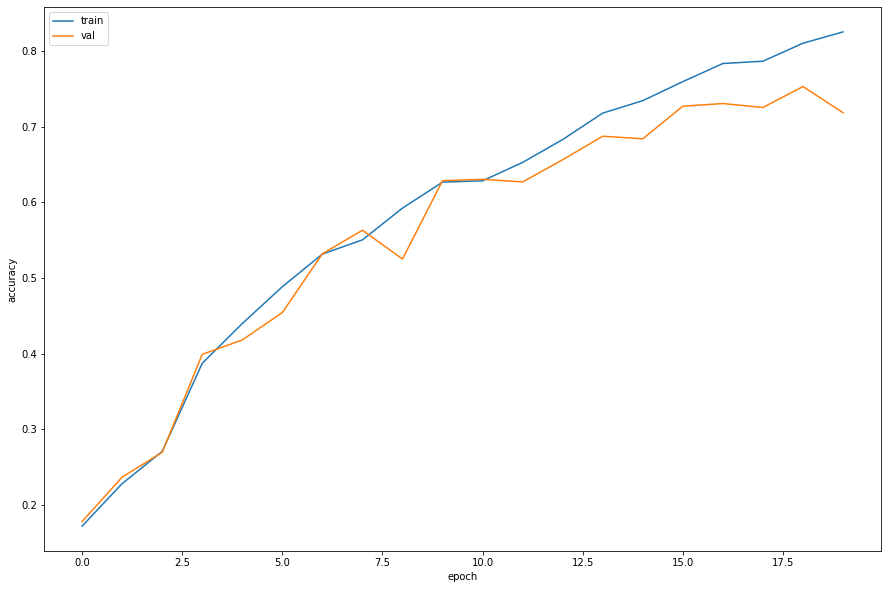

In [14]:
# validation fit model
plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('D:/Cancer_pele/history-7.png', format='png')
plt.show()

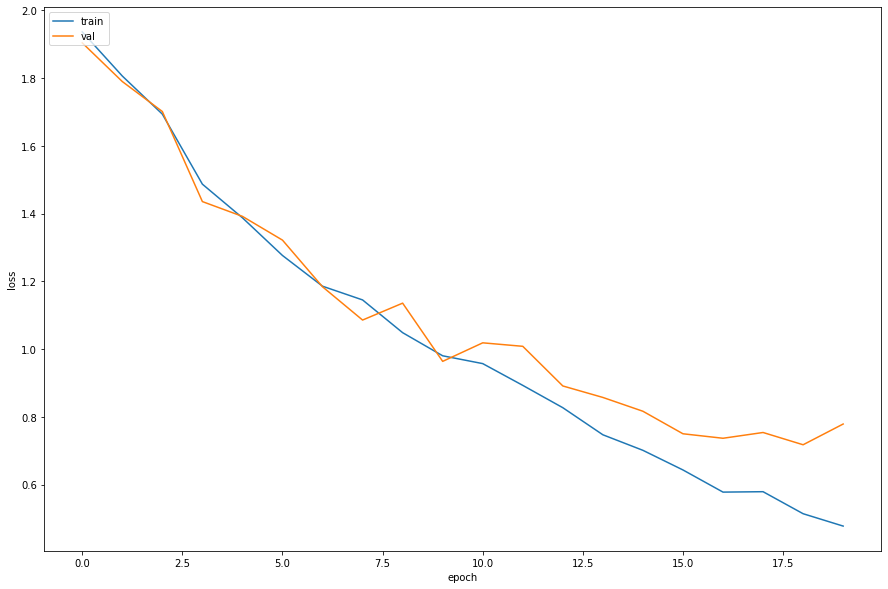

In [15]:
# validation loss model
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('D:/Cancer_pele/loss-7.png', format='png')
plt.show()